# TB Detection Model

This notebook use a CNN to detect Tuberculosis in chest x-ray data.


The data used to trained this model was downloaded from:
https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset/data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Libraries

In [ ]:
from imblearn.over_sampling import SMOTE
import h5py
import cv2
import random
import numpy as np              # Numpy library
import matplotlib.pyplot as plt # Visualization library
import tensorflow as tf         # Tensorflor library
import os
import math

import seaborn as sns;
sns.set()
sns.set(style="white")
sns.set(style="whitegrid", color_codes = True)

In [ ]:
# Displays a confusion matrix
def plot_heatmap(y_true, y_pred, class_names, title, ylabel, xlabel):
    fig, (ax) = plt.subplots(1, 1, figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel(xlabel, fontsize=12)
    fig.tight_layout()
    fig.subplots_adjust(top=1.25)
    plt.show()

In [ ]:
# This function displays images and their corresponding ground truth and
# predicted labels.
def display_predictions(images, labels, class_names, predicted_labels, max_display_images=100, border=2):
    """
    Displays images along with their ground truth and predicted labels.
    Correct predictions are shown with a blue border, incorrect ones with a red border.
    """
    numbers_to_display = min(len(labels), max_display_images)
    indices = np.random.choice(len(images), size=numbers_to_display, replace=False)

    num_cells = math.ceil(math.sqrt(numbers_to_display))
    plt.figure(figsize=(10, 10))

    for i, idx in enumerate(indices):
        img = images[idx]
        true_label = labels[idx]
        pred_label = int(predicted_labels[idx][0])

        ax = plt.subplot(num_cells, num_cells, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        # Determine border color
        color = 'green' if pred_label == true_label else 'blue'

        # Set border width and color
        for spine in ax.spines.values():
            spine.set_linewidth(border)
            spine.set_color(color)

        plt.imshow(img, cmap='gray')
        plt.xlabel(f"{class_names[pred_label]}")

    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.show()

## Data

**Loading**

In [ ]:
# This should match your Google Drive
path_data = '/content/drive/MyDrive/Experiment/Experiment/Data/data.h5'

# Load the gesture data
train_images = []
train_labels = []
test_images = []
test_labels = []

with h5py.File(path_data, "r") as f:
  train_images = f['train-images'][:]
  train_labels = f['train-labels'][:]
  test_images = f['test-images'][:]
  test_labels = f['test-labels'][:]

In [ ]:
# confirm the sizes of the data
print('Train set images: ', train_images.shape, 'labels: ', train_labels.shape )
print('Test set images: ', test_images.shape, 'labels: ', test_labels.shape )

Train set images:  (2940, 256, 256) labels:  (2940,)
Test set images:  (1260, 256, 256) labels:  (1260,)


In [ ]:
# Define class names
class_names = ['Normal', 'Tuberculosis']

**Normalization**

In [ ]:
# normalizing the values within the images for
# computational efficiency (from 0-255 scale to 0-1 scale)
train_images = (train_images.astype('float32'))/255.0
test_images = (test_images.astype('float32'))/255.0

**Class Balancing**

In [ ]:
# set the imagesize to the 1st dimension
imagesize = train_images.shape[1]

# Flattening the image array into 2D
# (making it [2940 images] x [all the pixels of the image in just one 1D array])
# to be suitable for SMOTE oversampling
train_images = train_images.reshape(2940, (imagesize*imagesize))

# Performing oversampling
smote = SMOTE(random_state=42)
train_images, train_labels = smote.fit_resample(train_images, train_labels)

# Unflattening the images now to use them for convolutional neural network
# (4914 images of 256x256 size, with 1 color channel (grayscale, as
# compared to RGB with 3 color channels))
train_images = train_images.reshape(-1, imagesize, imagesize, 1)
print(train_images.shape)

(4914, 256, 256, 1)


**Distribution of Training Samples**

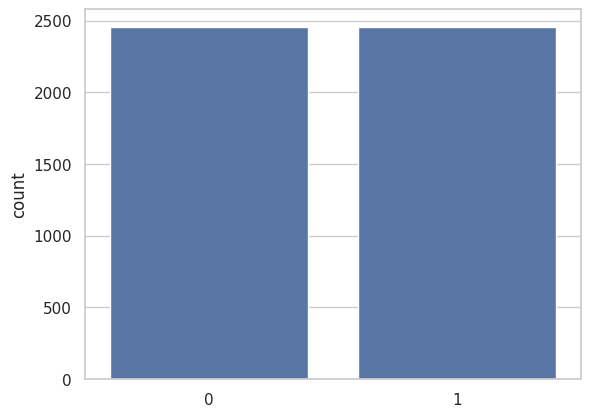

In [ ]:
# Visualize the distribution of the data
sns.countplot(x=train_labels)
plt.show()

**Examples of Training Samples**

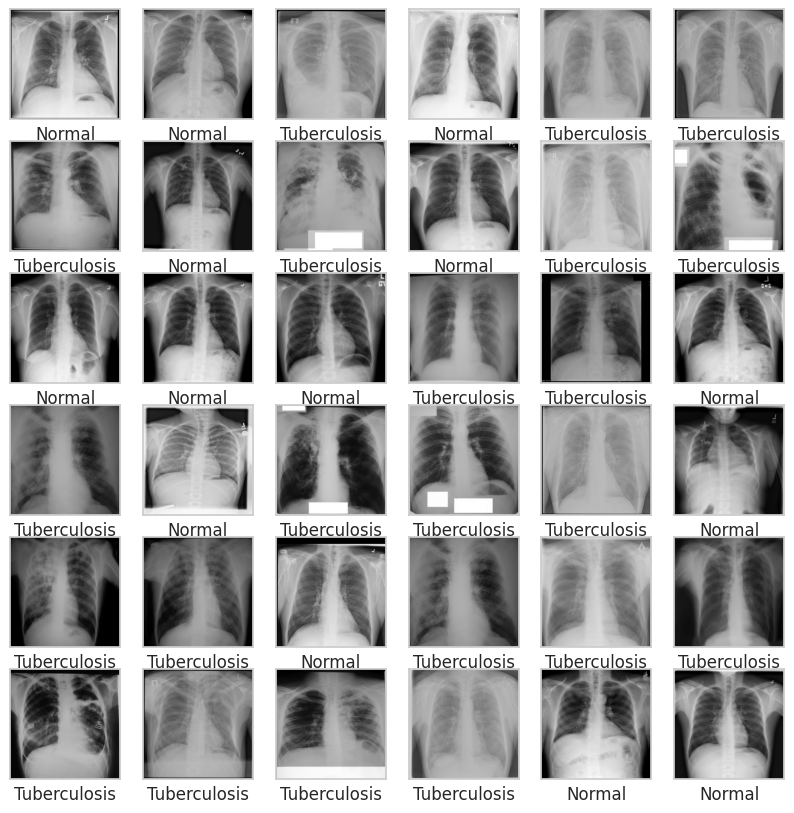

In [ ]:
# The number of images to visualize
num_images_to_display = 36

# Select random indices from the image array
indices = np.random.choice(train_images.shape[0], num_images_to_display)

# Visualize the images
plt.figure(figsize=(10,10))
for i in range(num_images_to_display):
    index = indices[i]
    label = train_labels[index]
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(train_images[index], cv2.COLOR_BGR2RGB))
    plt.xlabel( class_names[label] )
plt.show()

## Model

In [ ]:

# This function creates a CNN model and returns it
def create_cnn(input_shape, num_classes):

  # Create the model
  model = tf.keras.models.Sequential()

  # Add the input layer, which accepts images of the
  # same dimension as our training images
  model.add(tf.keras.layers.Input(shape=input_shape))

  # Add the first convolution layer consisting of 32 filters
  # of size (5,5). It uses the ReLU activation function and a padding of 'same'
  # to preserve the size of the input.
  model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'))

  # Add a maxpooling to downsample the output of the convolution layer by a (2,2) filter
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))

  # Add the second convolution layer consisting of 64 filters
  # of size (3,35). It uses the ReLU activation function and a padding of 'same'
  # to preserve the size of the input.
  model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))

  # Add a maxpooling to downsample the output of the convolution layer by a (2,2) filter
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))

  # Add the third convolution layer consisting of 128 filters
  # of size (3,3). It uses the ReLU activation function and a padding of 'same'
  # to preserve the size of the input.
  model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))

  # Add a maxpooling to downsample the output of the convolution layer by a (2,2) filter
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))

  # Flatten the feature maps into a linear vector for the fully-connected layers
  model.add(tf.keras.layers.Flatten())

  # Add a dropout layer to prevent overfitting.
  # The percentage represents the probability that a specific neuron will
  # be randomly dropped out during the training phase of the neural network.
  model.add(tf.keras.layers.Dropout(0.5))

  # Add a softmax layer to output a probability map for the 6 classes
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  return model

**Train the model**

In [ ]:
train_images.shape[1:]


(256, 256, 1)

In [ ]:
# create the model
cnn = create_cnn( input_shape = train_images.shape[1:], num_classes=len(class_names) )

# compiling the model with parameters best suited for the task at hand:
cnn.compile(
    loss='binary_crossentropy', #Best for binary classification
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), #Good starting LR for dataset of this size
    metrics=['accuracy'], #Looking for accuracy
)

# We use the ReduceLROnPlateau callback to reduce the learning rate
# to take smaller steps in increasing the accuracy whenever the
# learning rate plateaus (goes in the wrong direction)
# Doing this with patience=1, meaning it will perform this if it
# even plateaus for one epoch, since only 10 epochs are used
# factor=0.1 means that for every time the learning rate is reduced,
# it is reduced by a factor of 0.1 - it also won't go lower than 0.00001

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='accuracy',
    factor=0.1,
    patience=1,
    min_lr=0.00001,
    verbose=1)

# cnn.fit(imagetrain, labeltrain, batch_size=16, epochs=10, verbose=2, callbacks = [reduce_lr])

# Trains the model for a given number of epochs (iterations on a dataset) and validates it.
history = cnn.fit(train_images,        # training features
                  train_labels,        # training labels
                  epochs=10,           # number of iterations to train the model
                  batch_size=16,       # batch size for gradient descent
                  verbose=2,           # level ouf output to print
                  validation_data=(test_images, test_labels),  # test features and labels
                  callbacks = [reduce_lr])  # Learning rate control

Epoch 1/10
308/308 - 184s - 597ms/step - accuracy: 0.9082 - loss: 0.2278 - val_accuracy: 0.8246 - val_loss: 0.4611 - learning_rate: 0.0010
Epoch 2/10
308/308 - 213s - 693ms/step - accuracy: 0.9774 - loss: 0.0692 - val_accuracy: 0.9770 - val_loss: 0.0636 - learning_rate: 0.0010
Epoch 3/10
308/308 - 201s - 652ms/step - accuracy: 0.9825 - loss: 0.0522 - val_accuracy: 0.9635 - val_loss: 0.1008 - learning_rate: 0.0010
Epoch 4/10
308/308 - 193s - 627ms/step - accuracy: 0.9923 - loss: 0.0266 - val_accuracy: 0.9754 - val_loss: 0.0831 - learning_rate: 0.0010
Epoch 5/10

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
308/308 - 201s - 654ms/step - accuracy: 0.9923 - loss: 0.0230 - val_accuracy: 0.9643 - val_loss: 0.1056 - learning_rate: 0.0010
Epoch 6/10
308/308 - 211s - 685ms/step - accuracy: 0.9965 - loss: 0.0161 - val_accuracy: 0.9817 - val_loss: 0.0675 - learning_rate: 1.0000e-04
Epoch 7/10
308/308 - 192s - 624ms/step - accuracy: 0.9990 - loss: 0.0051 - val_accur

**Save the model**

In [26]:
# Save entire model to a file
path_model = '/content/drive/MyDrive/Experiment/Experiment/Model/'
cnn.save( os.path.join(path_model, 'cnn.keras')  )

NameError: name 'cnn' is not defined

**Visualize loss**

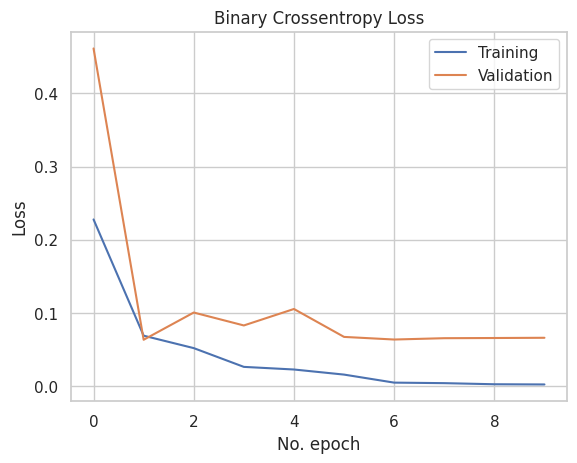

In [ ]:
# Visualize the training and test loss
# The graph of the loss should show the loss of the
# network decreasing as the training progresses.
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Binary Crossentropy Loss')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

**Visualize Accuracy**

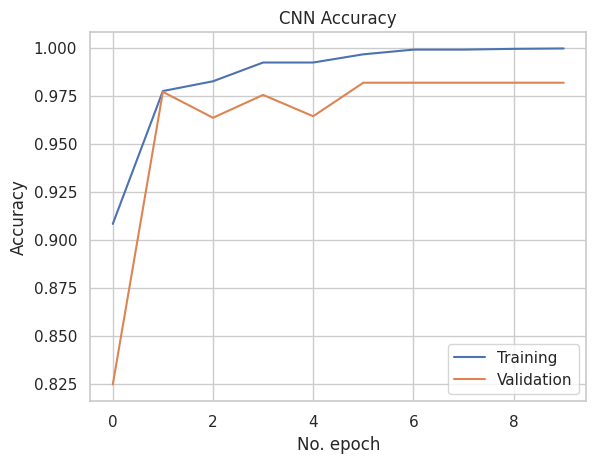

In [ ]:
# Visualize the training and test accuracy
# The graph of the accuracy should show the accuracy of the
# network increasing as the training progresses.
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('CNN Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.show()

## Results

**Load model**

In [ ]:
path_model = '/content/drive/MyDrive/Experiment/Experiment/Model/'
loaded_cnn = tf.keras.models.load_model(  os.path.join(path_model, 'cnn.keras')  )

**Evaluate the model**

In [ ]:
# Evaluate the model on the entire test dataset
# to determine its accuracy on unseen data
test_loss, test_acc = loaded_cnn.evaluate(test_images, test_labels)
print('Test accuracy: {:2.2f}%'.format(test_acc*100))

40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 648ms/step - accuracy: 0.9858 - loss: 0.0627
Test accuracy: 98.17%


In [ ]:
#Evaluating the data w/ multiple types of metrics
# print('Evaluating the CNN....')
# loaded_cnn.evaluate(test_images, test_labels, batch_size=16, verbose=2)

print('Advance test metrics:')
from sklearn.metrics import classification_report, confusion_matrix
predictions = loaded_cnn.predict(test_images, batch_size=32)
predicted_labels = (predictions > 0.5).astype('int32')
print(classification_report(test_labels, predicted_labels))
print(confusion_matrix(test_labels, predicted_labels))

Advance test metrics:
40/40 ━━━━━━━━━━━━━━━━━━━━ 24s 598ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1043
           1       0.94      0.95      0.95       217

    accuracy                           0.98      1260
   macro avg       0.97      0.97      0.97      1260
weighted avg       0.98      0.98      0.98      1260

[[1031   12]
 [  11  206]]


**Confusion matrix**

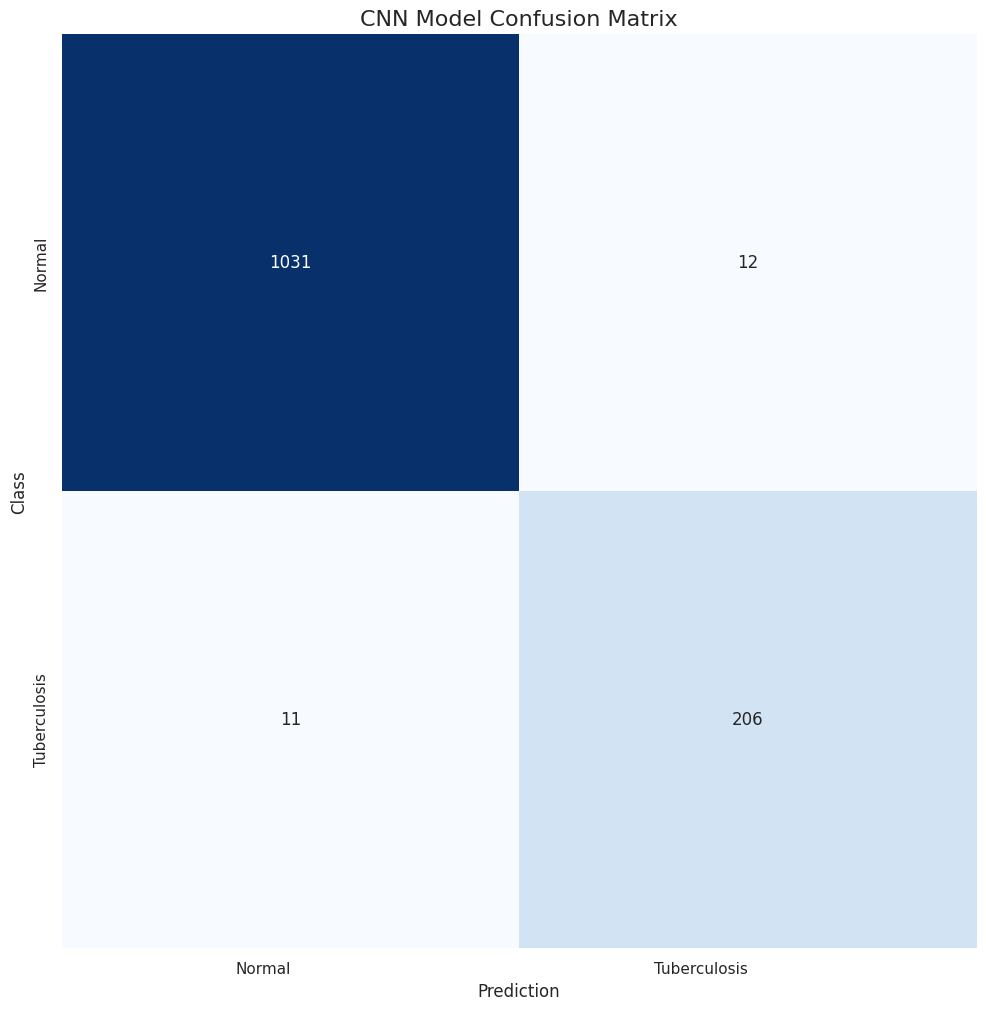

In [ ]:
# Display the confusion matrix
#plot_heatmap(y_test, pred_classes, classnames, title="CNN Model Confusion Matrix", ylabel='Gesture', xlabel='Prediction')
plot_heatmap(test_labels, predicted_labels, class_names, title="CNN Model Confusion Matrix", ylabel='Class', xlabel='Prediction')

**Test Results**

Display prediction results for our model

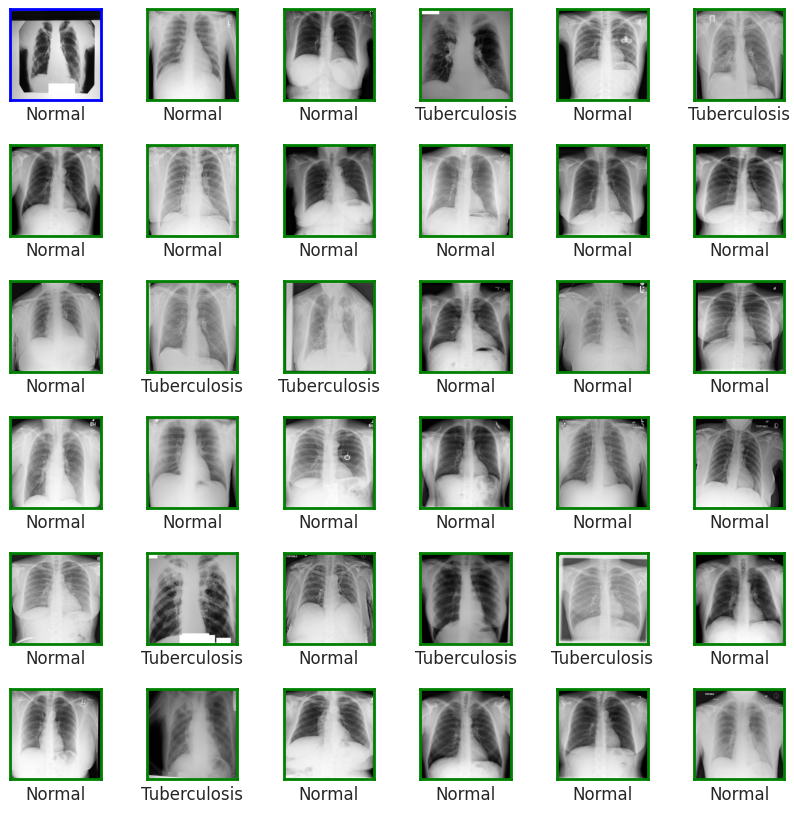

In [ ]:
# Display predictions from our model.
# Correct predictions are rendered with blue border, and incorrect
# predictions are rendered with red border.
display_predictions(test_images, test_labels, class_names, predicted_labels, 36, border=2)

## Using the model

In [ ]:
# Load the model
path_model = '/content/drive/MyDrive/Experiment/Experiment/Model/'
loaded_cnn = tf.keras.models.load_model(  os.path.join(path_model, 'cnn.keras')  )

**Example image of TB**

(256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Text(0.5, 0, 'TB Detected')

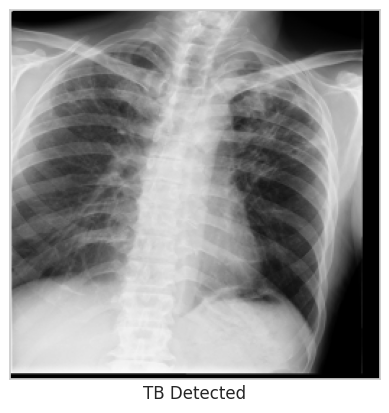

In [ ]:
imagesize = 256

# Load an image to test the model
path_image = '/content/drive/MyDrive/Experiment/Experiment/Data/Samples/Tuberculosis-250.png'
image = cv2.imread(path_image, cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (imagesize, imagesize))

print(image.shape)

# Process the image with the model
img_array = np.expand_dims(image, axis=0)  # Add batch dimension
prediction = loaded_cnn.predict(img_array)


# Since we are doing binary classification with sigmoid,
# we can simply check the probability.
if prediction[0] > 0.5:
  results = "TB Detected"
else:
  results = "No TB Detected"

# visualize the image
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.xlabel( results )

Example of normal image (without TB)

(256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Text(0.5, 0, 'No TB Detected')

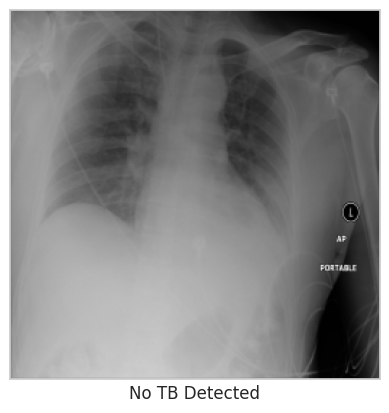

In [ ]:
imagesize = 256

# Load an image to test the model
path_image = '/content/drive/MyDrive/Experiment/Experiment/Data/Samples/Normal-33.png'
image = cv2.imread(path_image, cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (imagesize, imagesize))

print(image.shape)

# Process the image with the model
img_array = np.expand_dims(image, axis=0)  # Add batch dimension
prediction = loaded_cnn.predict(img_array)


# Since we are doing binary classification with sigmoid,
# we can simply check the probability.
if prediction[0] > 0.5:
  results = "TB Detected"
else:
  results = "No TB Detected"

# visualize the image
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.xlabel( results )